<h1 align="center">Hacettepe University<br>Department of Computer Science</h1> 
<h2 align="center">BBM 418 - Computer Vision Laboratory<br>2022 Spring</h2>
<h3 align="center">Assignment 1</h3>
<h3 align="left">Name    :    Murat Çelik</h3>
<h3 align="left">ID      :    21827263</h3>
<h4 align="right">Due on March 19, 2022</h4>


## Table of Contents
- [1 - Introduction](#1)
- [2 - DataSet](#2)
- [3 - Edge Map](#3)
    - [3.1 - Sobel Edge Detector](#3.1)
    - [3.2 - Laplacian Edge Detector ](#3.2)
    - [3.3 - Canny Edge Detector ](#3.3)
    - [3.4 - Edge Detectors Comparision ](#3.4)
    - [3.5 - More examples of Canny Edge Detector ](#3.5)
- [4 - Hough Transform](#4)
    - [4.1 - Intersection over Union (IoU)](#4.1)
- [5 - Experiment Results](#5)
    - [5.1 - Successful Results](#5.1)
    - [5.2 - Failed Results](#5.2)
- [6 - Conclusion](#6)
- [7 - References](#7)

## 1. Introduction <a name='1'></a>
In this assignment, work was done on edge detection methods and Hough Transform. Edge detection is an image processing technique that attempts to locate the boundaries of objects within images by detecting discontinuities in brightness. The Hough transform is a technique that can be used to detect features of a particular shape in an image. In this assignment, we defined this shape as a circle.  

## 2. DataSet <a name='2'></a>
Dataset consists of sample images including circular objects. For each image, there is also a txt file provided for ground-truth information showing where the circular objects are placed on the image. 

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageOps, ImageFilter
from math import sqrt,sin, asin
import random
from collections import defaultdict
import pandas as pd
%matplotlib inline

In [ ]:
try : 
    os.chdir("dataset MY") # only run once 
except:
    print("Already Done")
try : 
    os.mkdir("GT_Images")  # only run once 
except : 
    print("Already Done")

Already Done


In [ ]:
img_path_list = ['8','10','94','27']
for num_of_Picture in img_path_list:
    f = open("GT/" + num_of_Picture + ".txt", "r", encoding="utf8")
    GT_info_list = [list(map(int,(list(map(float,x.strip().split(" ")))))) for x in f]
    f.close()
    GT_info_list.pop(0)
    image = cv2.imread("Images/"+num_of_Picture+".jpg")
    for x,y,r in GT_info_list:
        cv2.circle(image,(x, y), r, (255,255,51),2)
    cv2.imwrite("GT_Images/GT_"+num_of_Picture+".jpg",image)
    f.close()

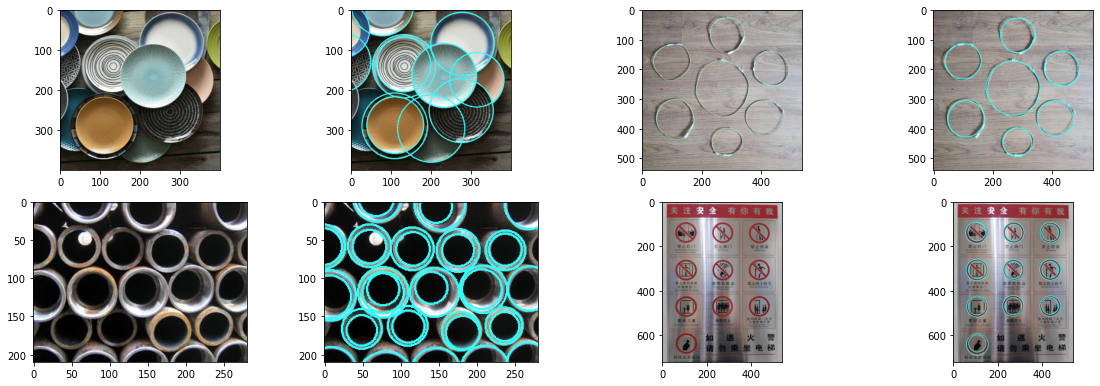

In [ ]:
images = []
for index in img_path_list:
    images.append(mpimg.imread('Images/'+ index +'.jpg'))
    images.append(mpimg.imread('GT_Images/GT_'+ index +'.jpg'))
plt.figure(figsize=(20,10))
for i, image in enumerate(images):
    plt.subplot(len(images) // 4 + 1, 4, i + 1)
    plt.imshow(image)

Above are examples of original images and images which showing circles in the original image. The information that determines the circles on the images is given in the "GT" folder in the dataset. This information is displayed on the original image with the help of opencv library. 

## 3. Edge Map <a name='3'></a>
An edge map is an image that indicated where edges are in the image. There are different techniques such as Sobel Edge detector, Laplacian Edge detector, Canny Edge detector. 

In [ ]:
def plot_filters(function, name):
    one, two = str(random.randint(3,113)), str(random.randint(3,113))
    input_image_1, gray = transform2GRAY("Images/"+ one +".jpg")
    grad_1 = function(gray)
    input_image_2, gray = transform2GRAY("Images/"+ two +".jpg")
    grad_2 = function(gray)
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 4, 1)
    imgplot = plt.imshow(input_image_1)
    ax.set_title('Original Image')
    ax = fig.add_subplot(1, 4, 2)
    imgplot = plt.imshow(grad_1, cmap='gray', vmin=0, vmax=255)
    ax.set_title(name + ' Filter')
    ax = fig.add_subplot(1, 4, 3)
    imgplot = plt.imshow(input_image_2)
    ax.set_title('Original Image')
    ax = fig.add_subplot(1, 4, 4)
    imgplot = plt.imshow(grad_2, cmap='gray', vmin=0, vmax=255)
    ax.set_title(name + ' Filter')
def transform2GRAY(file):
    input_image = cv2.imread(file)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)
    blur = cv2.GaussianBlur(input_image, (3, 3), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    #(thresh, gray) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    return input_image, gray

### 3.1. Sobel Edge Detector <a name='3.1'></a>
The Sobel filter uses two 3 x 3 cores. One of these analyze the horizontal direction and one the vertical direction in images. 

<img src="https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/sobmasks.gif">


These can be combined with $|G| = \sqrt(G_x^2 + G_y^2)$ or $|G| = |G_x| + |G_y|$ to find the absolute magnitude of the transition at each point and the direction of that transition .

In [ ]:
def sobel_edge_detector(gray):    

    grad_x = cv2.Sobel(gray, cv2.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(gray, cv2.CV_16S, 0, 1, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)

    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)

    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return grad

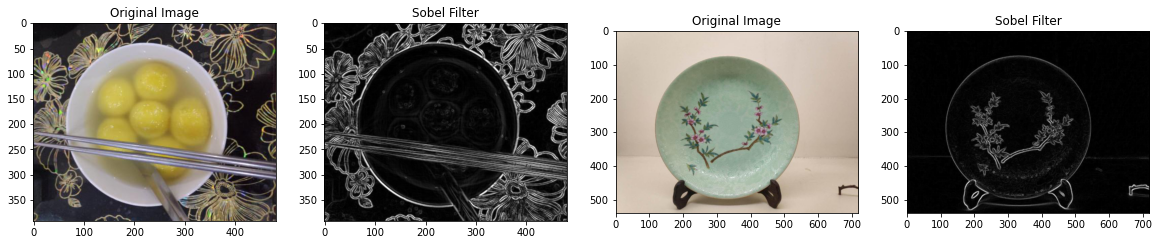

In [ ]:
plot_filters(sobel_edge_detector,"Sobel")

### 3.2. Laplacian Edge Detector <a name='3.2'></a>

It is one of the edge detection methods that highlights regions with rapid density change.Generally, the following kernels are used: 

<img src="https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/lapmask2.gif">

The main formula is as follows:   
$ Laplace(f) = \dfrac{\partial^{2} f}{\partial x^{2}} + \dfrac{\partial^{2} f}{\partial y^{2}} $

In [ ]:
def laplacian_edge_detector(gray):    
    grad = cv2.Laplacian(gray, cv2.CV_16S, ksize=3)
    grad = cv2.convertScaleAbs(grad)
    return grad

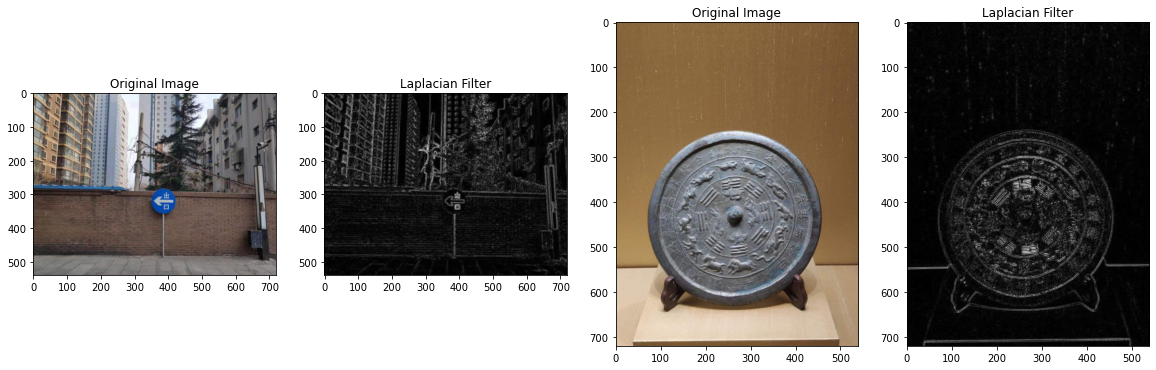

In [ ]:
plot_filters(laplacian_edge_detector,"Laplacian")

### 3.3. Canny Edge Detector <a name='3.3'></a>

The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images.
Step :
   1. Noise Reduction using Gaussian filter
   2. Get help from the Sobel kernel. At this point our formulas is: $ Edge\_Gradient \; (G) = \sqrt{G_x^2 + G_y^2} \\ Angle \; (\theta) = \tan^{-1} \bigg(\frac{G_y}{G_x}\bigg) $
   3. Gradient direction is always perpendicular to edges, so it is rounded to  vertical or horizontal or two diagonal directions which four angles representing
   4. Non-maximum Suppression
   5. Hysteresis Thresholding

In [1]:
def canny_edge_detector(gray):
    high_thresh, thresh_im = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    lowThresh = 0.5 * high_thresh
    grad = cv2.Canny(gray,lowThresh,high_thresh)
    return  grad

In [2]:
plot_filters(canny_edge_detector,"Canny")

NameError: ignored

### 3.4.  Edge Detectors Comparision <a name='3.4'></a>

Canny Edge Detector was chosen as the choice with its thicker and cleaner lines. 

Text(0.5, 1.0, 'Canny Filter')

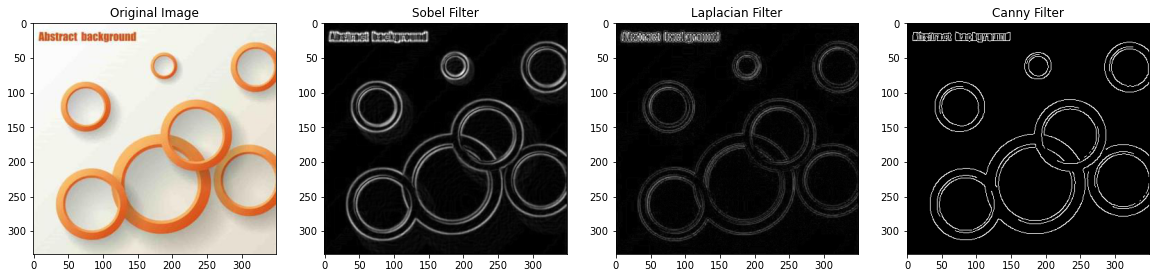

In [ ]:
file = "Images/110.jpg"
input_image, gray = transform2GRAY(file)
grad_sobel = sobel_edge_detector(gray)
grad_laplacian = laplacian_edge_detector(gray)
grad_canny = canny_edge_detector(gray)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(input_image)
ax.set_title('Original Image')
ax = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(grad_sobel, cmap='gray', vmin=0, vmax=255)
ax.set_title('Sobel Filter')
ax = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(grad_laplacian, cmap='gray', vmin=0, vmax=255)
ax.set_title('Laplacian Filter')
ax = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(grad_canny, cmap='gray', vmin=0, vmax=255)
ax.set_title('Canny Filter')

### 3.5.  More examples of Canny Edge Detector <a name='3.5'></a>

Samples for the selected edge detector have been published below. These samples were extracted as random images. Different examples may be encountered each time the code is run. 

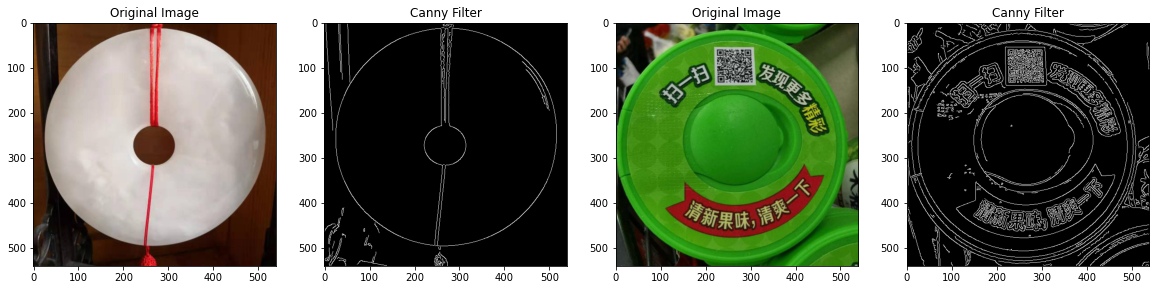

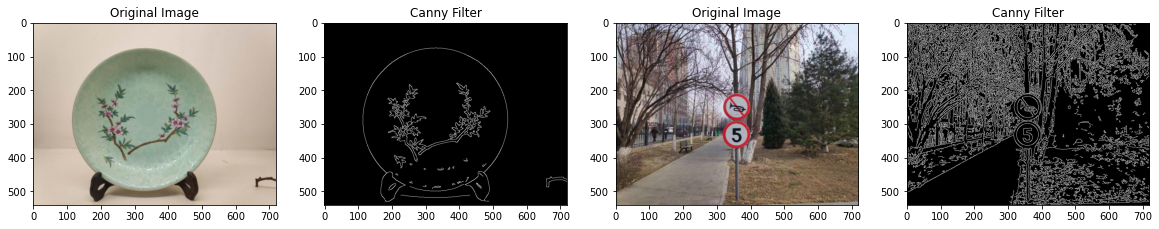

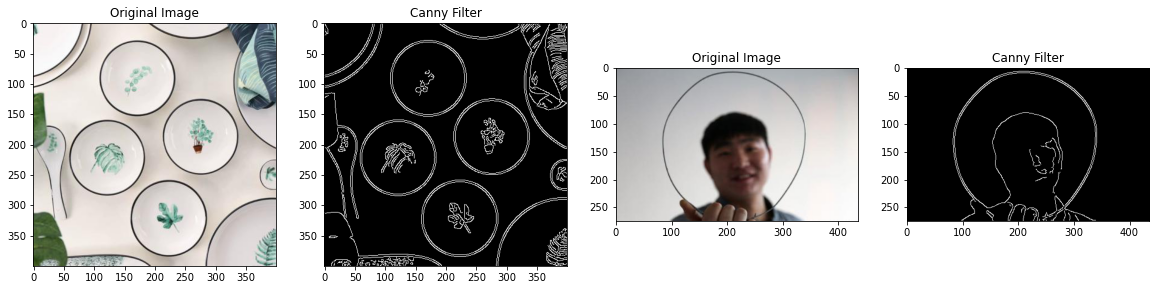

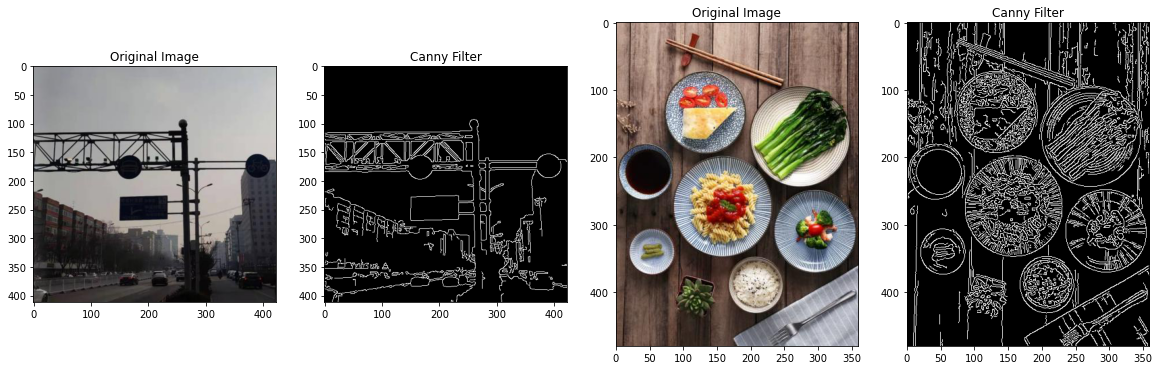

In [ ]:
for x in range(4):
    plot_filters(canny_edge_detector,"Canny")

## 4. Hough Transform <a name='4'></a>

The Hough transform is a method designed to find and represent the properties of a particular shape in an image. 

1. Blur and grayscale processing is applied to a image. 
2. The resulting image is given to the canny edge detector to create an edge map. 
3. The prepared edge map is scanned to find the circle. Searching for circles formed by clustering points that are at a certain distance from a certain center point. 
4. Estimated circles detected are recorded. 
5. If some detected circles are observed to be almost identical to each other, those predictions are eliminated. 
6. We save the estimated values of the grunt truth values. 

In [ ]:
try : 
    os.mkdir("GT_Predict")  # only run once - this file contains gt information
except : 
    print("Already Done")

Already Done


In [ ]:
def hough_transform(num_of_Pic, r_change = 2, num_of_thetas = 180, bin_threshold = 0.5):

    file = "Images/"+num_of_Pic+".jpg"       # File Name
    input_image, gray = transform2GRAY(file) # Get original pictures and grayscale, blured pictures of original pictures
    grad_canny = canny_edge_detector(gray)   # use CANNY EDGE DETECTOR
    
    # ground-truth information of pictures (include x point, y point and r (radius))
    f = open("GT/" + num_of_Pic + ".txt", "r", encoding="utf8")
    GT_info_list = [list(map(int,(list(map(float,x.strip().split(" ")))))) for x in f]
    f.close()
    GT_info_list.pop(0)
    r_list = [x[2] for x in GT_info_list]
    f.close()
    
    # hyperparameter arrangement 
    r_min = min(r_list) - 5
    r_max = max(r_list) + 5
    # for threshold value of nearly equal circles 
    thetas = np.arange(0, 360, step=(360 / num_of_thetas)) # Angle values to be controlled 
    all_r_values = np.arange(r_min, r_max, step=r_change) # Radius values to be controlled 
    
    # calculate angles
    cos_angles_num = np.cos(np.deg2rad(thetas))
    sin_angles_num = np.sin(np.deg2rad(thetas))
    
    # determination of possible circle points 
    possible_circle = []
    for r in all_r_values:
        for thetas in range(num_of_thetas):
            possible_circle.append((r, int(r * cos_angles_num[thetas]), int(r * sin_angles_num[thetas])))
    
    nonzero = np.nonzero(grad_canny) #we do not process points with a value of 0 
    
    # we have to set an accumalator for each circle quest 
    accumulator = defaultdict(int)
    for index in range(len(nonzero[0])):
        y = nonzero[0][index]
        x = nonzero[1][index]
        for r, cos_value, sin_value in possible_circle:
            x_center = x - cos_value
            y_center = y - sin_value
            accumulator[(x_center, y_center, r)] += 1 
    
    # we determine all circle shapes
    all_predict_circle = []
    for candidate_circle, votes in sorted(accumulator.items(), key=lambda i: -i[1]):
        x, y, r = candidate_circle
        current_vote_percentage = votes / num_of_thetas
        if current_vote_percentage >= bin_threshold : 
            all_predict_circle.append((x, y, r, current_vote_percentage))
    
    # we should eliminate points that are close to each other or very similar to each other. 
    elimination_predict = []
    for x, y, r, v in all_predict_circle:
        if all((abs(x - xc) > 3 or abs(y - yc) > 3) or abs(r - rc) > 5 for xc, yc, rc, v in elimination_predict):
            elimination_predict.append((x, y, r, v))
    out_circles_post = elimination_predict
    
    # we should save GT information about prediction results
    f = open("GT_Predict/"+num_of_Pic+".txt", "w")
    f.write(str(len(out_circles_post)) + "\n")
    for x,y,r,v in out_circles_post:
        f.write(str(x) + " "+ str(y) + " " + str(r) + "\n")
    f.close()

The hyperparameters are determined as follows:
- Radius (r_change) = 2 This value represents the radius change after each calculation.
- Theta number(num_of_thetas) = 120 This value represents how many angular values are looked at in each calculation.
- Threshold (bin_threshold) = 0.5 This value represents what percentage of the circle must be seen to produce a circle shape. 

In [ ]:
for x in os.listdir("./Images")[::-1]:
    #print(x)
    try: # memory bound error
        hough_transform(x[:-4], r_change = 2, num_of_thetas = 120, bin_threshold = 0.5)
    except:
        print(x)

75.jpg


### 4.1 Intersection over Union (IoU)  <a name='4.1'></a>

The IOU (Intersection over Union) is the score that determines the overlap of two areas with each other. The higher the intersection, the higher this value. 

In this assignment, the formulas specified in the article "CircleNet: Anchor-free Detection with Circle Representation" were used to calculate the IoU score for the circles. 

$ IoU = \dfrac{Area(A\cap B)}{Area(A\cup B)}  $ 


**Note : In this assignment, IoU score calculation is done only between intersecting circles.**

In [ ]:
# This function returns both the actual GT(ground-truth) information and the estimated GT(ground-truth ) information of a picture. 
def get_GT_info(num_of_pic):
    f = open("GT/" + num_of_pic + ".txt", "r", encoding="utf8")
    GT_info_list = [list(map(int,(list(map(float,x.strip().split(" ")))))) for x in f]
    f.close()
    GT_info_list.pop(0)

    f = open("GT_Predict/" + num_of_pic + ".txt", "r", encoding="utf8")
    GT_info_list_predict = [list(map(int,(list(map(float,x.strip().split(" ")))))) for x in f]
    f.close()
    GT_info_list_predict.pop(0)
    
    return GT_info_list, GT_info_list_predict

In [ ]:
def intersection_over_union(GT_info_list,GT_info_list_predict):
    Ax, Ay, rA = GT_info_list
    Bx, By, rB = GT_info_list_predict
    if rB > rA :
        Ax, Ay, rA = GT_info_list_predict
        Bx, By, rB = GT_info_list
        
    d = sqrt((Bx-Ax)**2 + (By-Ay)**2) # distance between centers 
    # area of circles
    area_of_A = np.pi * rA**2
    area_of_B = np.pi * rB**2

    
    if rA == rB and d == 0: # same circle
        return 1
    if d >= (rA + rB):  # circles that do not intersect 
        return 0
    if d <= abs(rA - rB): # circles covering one another 
        area_intersect = min(area_of_A,area_of_B)
        area_union = max(area_of_A, area_of_B)
        return area_intersect / area_union 
    
    Lx = (rA**2 - rB**2 + d**2) / (2 * d)
    Ly = sqrt((rA**2 - Lx**2))
    try: # for memory error
        area_intersect = rA**2 * asin(Ly / rA) + rB**2 * asin(Ly/rB) - Ly * (Lx + sqrt(rB**2 - rA**2 + Lx**2))  
    except:
        area_intersect = 0
    area_union = area_of_A + area_of_B - area_intersect
    if (Lx > d): # If the circles cover each other's center 
        return 1 - (area_intersect / area_union)
    return area_intersect / area_union

## 5. Experiment Result <a name='5'></a>

The results obtained in a wide variety of data sets seem sufficient at the first stage. These results are shared in the table below. It was added to the test results with the image samples. 

In [ ]:
def get_results():
    df = pd.DataFrame(columns=["Pictures Name","Intersection over Union Score","Num of Circle in Original","Num of Circle in Predicted","Number of intersecting circle"])
    df.style.set_properties(**{'text-align': 'center'})
    for file_name in os.listdir("./GT_Predict"):
        num_of_pic = file_name[:-4]
        file = "Images/"+ num_of_pic+".jpg"
        input_image, gray = transform2GRAY(file)
        GT_info_list, GT_info_list_predict = get_GT_info(num_of_pic)
        liste = []
        for x in GT_info_list_predict:
            for y in GT_info_list:
                iou_score = intersection_over_union(x,y)
                if iou_score != 0:
                    liste.append(iou_score)
        if len(GT_info_list)>0 and len(GT_info_list_predict) and iou_score>0:
            average_iou_score = np.mean(liste)
        else:
            average_iou_score = 0
        intersection_over_Union_Score = round(100*average_iou_score,2)
        num_of_circle_original_photo = len(GT_info_list)
        num_of_circle_predicted = len(GT_info_list_predict)
        num_of_intersecting_circles =  len(liste)
        df.loc[len(df)] = [file_name,intersection_over_Union_Score,num_of_circle_original_photo,num_of_circle_predicted,num_of_intersecting_circles]
    return df
df_results = get_results()

In [ ]:
# df_results.to_csv("results.csv")

In [ ]:
df_results = pd.read_csv("results.csv", index_col= "Pictures Name")
df_results = df_results.drop(["Unnamed: 0"],axis=1)
df_results.head(10)

Intersection over Union Score  Num of Circle in Original  \
Pictures Name                                                             
10.txt                                  0.00                          7   
100.txt                                66.03                          2   
101.txt                                90.01                          1   
102.txt                                83.35                         31   
103.txt                                21.99                          9   
104.txt                                 0.00                          2   
105.txt                                49.89                          4   
106.txt                                43.24                          2   
107.txt                                 0.00                          7   
108.txt                                 0.00                          4   

               Num of Circle in Predicted  Number of intersecting circle  
Pictures Name                                                             
10.txt                                  0                              0  
100.txt                                 1                              2  
101.txt                                 1                              1  
102.txt                                33                             31  
103.txt                                 7                             25  
104.txt                                 0                              0  
105.txt                                 1                              4  
106.txt                                 1                              2  
107.txt                                 0                              0  
108.txt                                 0                              0

In [ ]:
def example(num_of_Pic):
    file = "Images/"+ num_of_Pic+".jpg"
    input_image, gray = transform2GRAY(file)
    GT_info_list, GT_info_list_predict = get_GT_info(num_of_Pic)
    output_img_original = input_image.copy()
    output_img_predict = input_image.copy()
    output_img_all = input_image.copy()
    for x, y, r in GT_info_list:
        output_img_original = cv2.circle(output_img_original, (x,y), r, (0,255,0), 2)
        output_img_all = cv2.circle(output_img_all, (x,y), r, (0,255,0), 2)
    for x, y, r in GT_info_list_predict:
        output_img_predict = cv2.circle(output_img_predict, (x,y), r, (0,0,255), 2)
        output_img_all = cv2.circle(output_img_all, (x,y), r, (0,0,255), 2)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 3, 1)
    imgplot = plt.imshow(output_img_original)
    ax.set_title('Original Image')
    ax = fig.add_subplot(1, 3, 2)
    imgplot = plt.imshow(output_img_predict)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 3)
    imgplot = plt.imshow(output_img_all)
    ax.set_title('Intersection')

### 5.1 Successful Results   <a name='5.1'></a>

Successful results are given below. 10 of these results are shared below with their data. These results show us that circles with sharp lines are detected more effectively by the algorithm. 

In [ ]:
df_results.sort_values(by=['Intersection over Union Score'],ascending=False).head(10)

Intersection over Union Score  Num of Circle in Original  \
Pictures Name                                                             
51.txt                                 96.19                          1   
64.txt                                 93.51                          2   
95.txt                                 92.86                          4   
72.txt                                 92.46                          1   
68.txt                                 92.24                          2   
82.txt                                 91.84                          1   
81.txt                                 91.12                          2   
22.txt                                 90.02                          2   
101.txt                                90.01                          1   
113.txt                                90.01                          1   

               Num of Circle in Predicted  Number of intersecting circle  
Pictures Name                                                             
51.txt                                  4                              1  
64.txt                                  1                              2  
95.txt                                  1                              1  
72.txt                                  1                              1  
68.txt                                  2                              2  
82.txt                                  1                              1  
81.txt                                  3                              2  
22.txt                                  3                              1  
101.txt                                 1                              1  
113.txt                                 1                              1

Intersection over Union Score    77.29
Num of Circle in Original        13.00
Num of Circle in Predicted       11.00
Number of intersecting circle    11.00
Name: 5.txt, dtype: float64


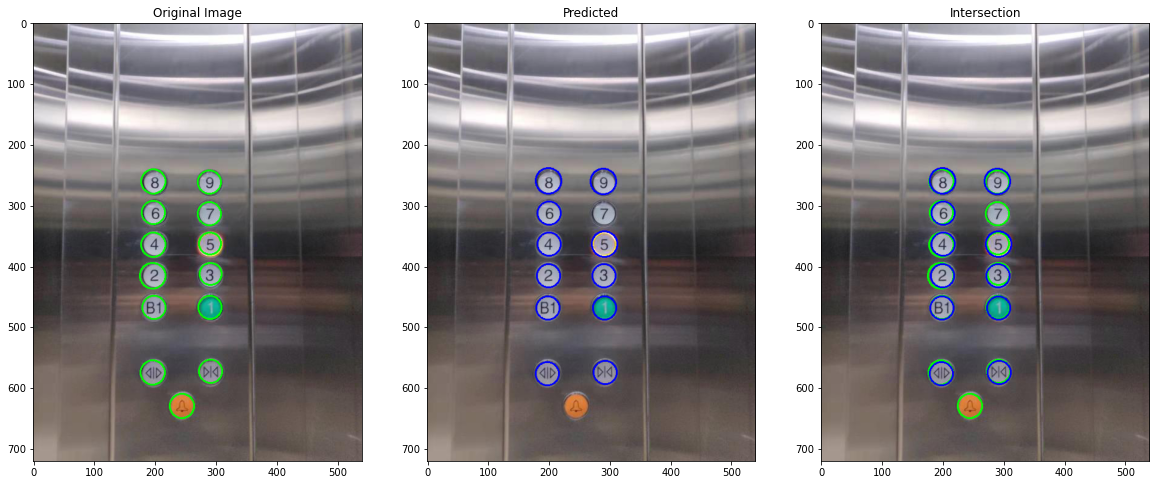

In [ ]:
file = "5"
example(file)
print(df_results.loc[file + ".txt"])

Intersection over Union Score    74.5
Num of Circle in Original        20.0
Num of Circle in Predicted       10.0
Number of intersecting circle    20.0
Name: 27.txt, dtype: float64


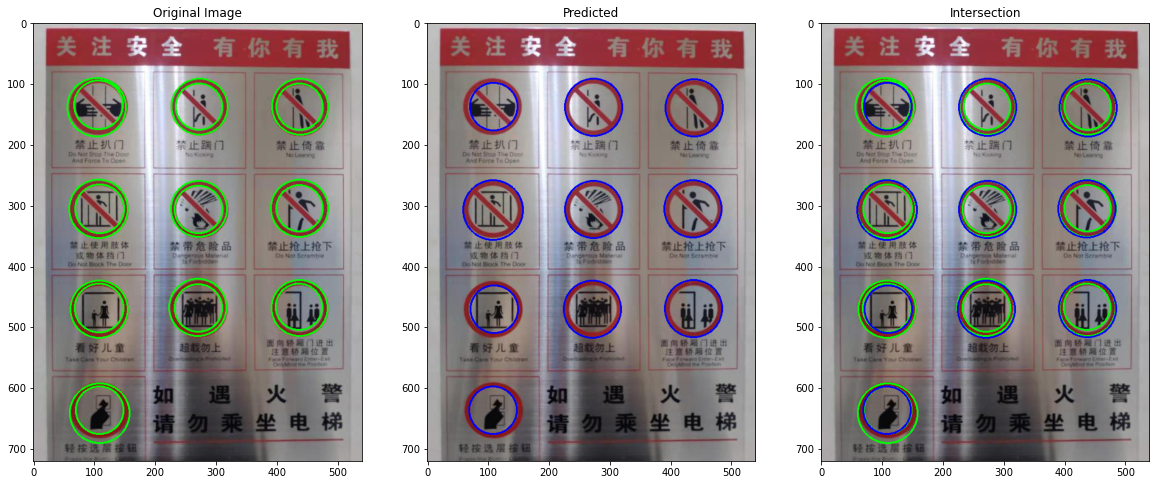

In [ ]:
file = "27"
example(file)
print(df_results.loc[file + ".txt"])

Intersection over Union Score    79.69
Num of Circle in Original         7.00
Num of Circle in Predicted        8.00
Number of intersecting circle     8.00
Name: 46.txt, dtype: float64


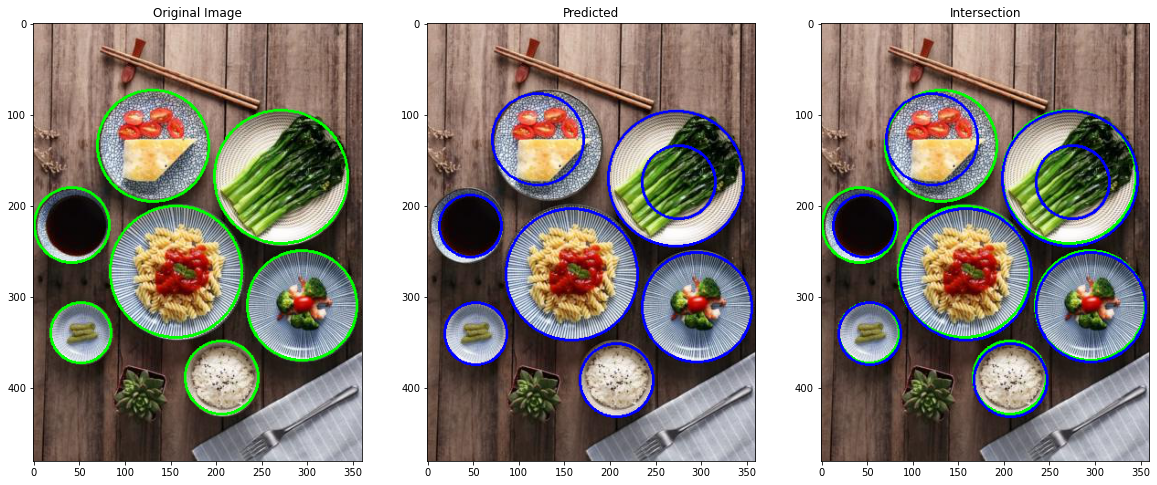

In [ ]:
file = "46"
example(file)
print(df_results.loc[file + ".txt"])

Intersection over Union Score    93.51
Num of Circle in Original         2.00
Num of Circle in Predicted        1.00
Number of intersecting circle     2.00
Name: 64.txt, dtype: float64


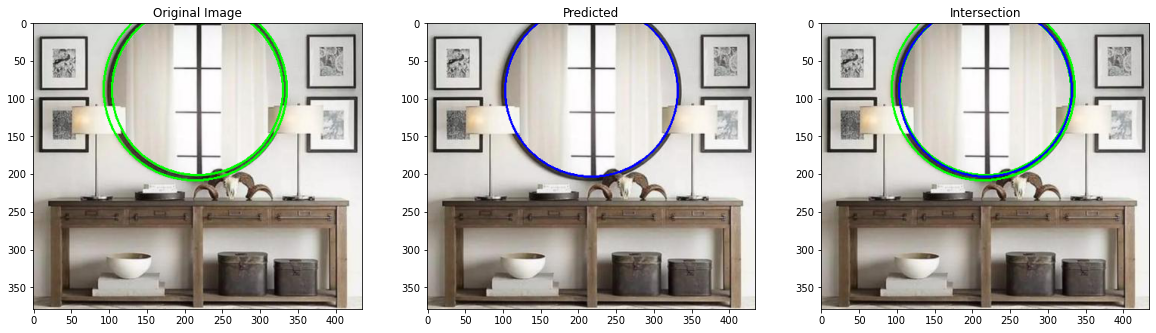

In [ ]:
file = "64"
example(file)
print(df_results.loc[file + ".txt"])

Intersection over Union Score    92.24
Num of Circle in Original         2.00
Num of Circle in Predicted        2.00
Number of intersecting circle     2.00
Name: 68.txt, dtype: float64


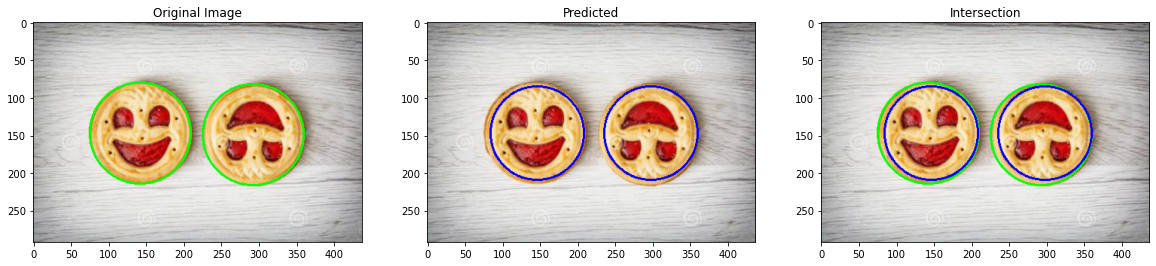

In [ ]:
file = "68"
example(file)
print(df_results.loc[file + ".txt"])

Intersection over Union Score    62.67
Num of Circle in Original        16.00
Num of Circle in Predicted       13.00
Number of intersecting circle    26.00
Name: 69.txt, dtype: float64


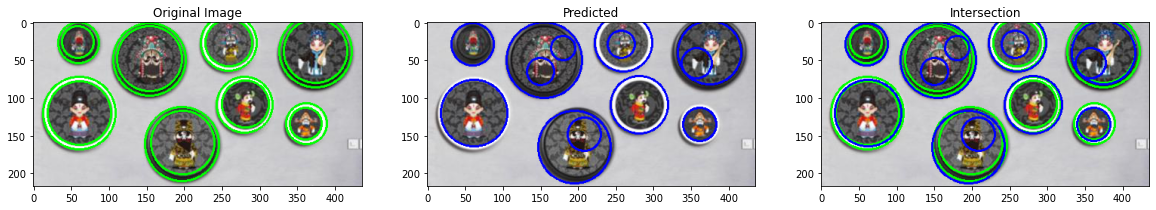

In [ ]:
file = "69"
example(file)
print(df_results.loc[file + ".txt"])

Intersection over Union Score    91.12
Num of Circle in Original         2.00
Num of Circle in Predicted        3.00
Number of intersecting circle     2.00
Name: 81.txt, dtype: float64


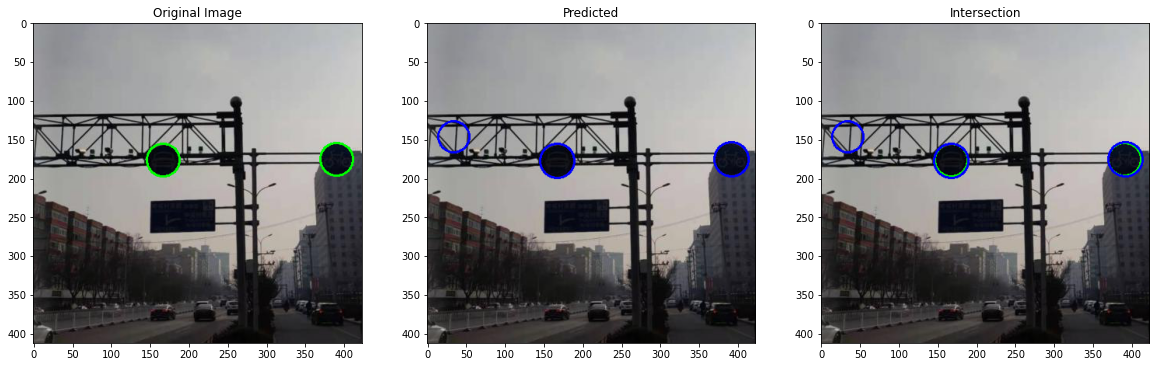

In [ ]:
file = "81"
example(file)
print(df_results.loc[file + ".txt"])

Intersection over Union Score    90.01
Num of Circle in Original         1.00
Num of Circle in Predicted        1.00
Number of intersecting circle     1.00
Name: 101.txt, dtype: float64


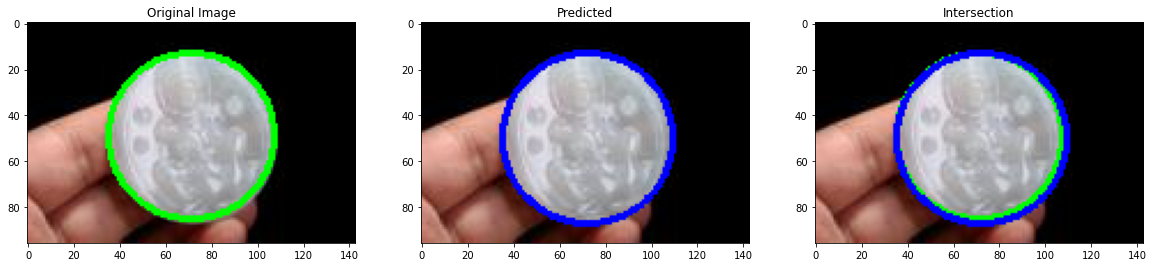

In [ ]:
file = "101"
example(file)
print(df_results.loc[file + ".txt"])

Intersection over Union Score    83.35
Num of Circle in Original        31.00
Num of Circle in Predicted       33.00
Number of intersecting circle    31.00
Name: 102.txt, dtype: float64


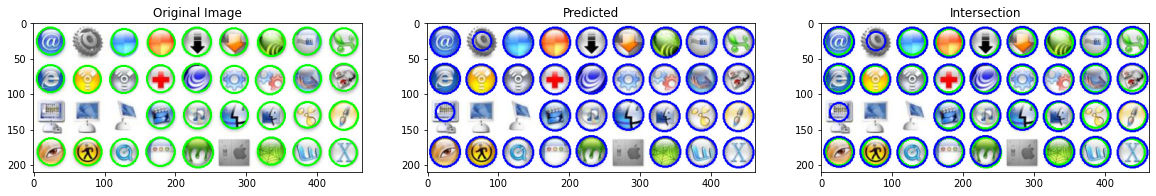

In [ ]:
file = "102"
example(file)
print(df_results.loc[file + ".txt"])

Intersection over Union Score    90.01
Num of Circle in Original         1.00
Num of Circle in Predicted        1.00
Number of intersecting circle     1.00
Name: 113.txt, dtype: float64


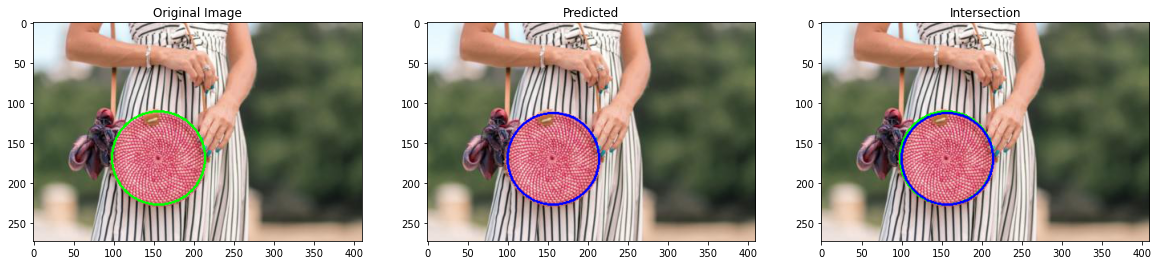

In [ ]:
file = "113"
example(file)
print(df_results.loc[file + ".txt"])

### 5.2 Failed Results    <a name='5.2'></a>

Below are the unsuccessful results and their reasons. These reasons are supported by visual examples. 


Because some parts of the pipes, which appear as circles in the figure below, are not visible in the image, the algorithm is unable to detect this. 

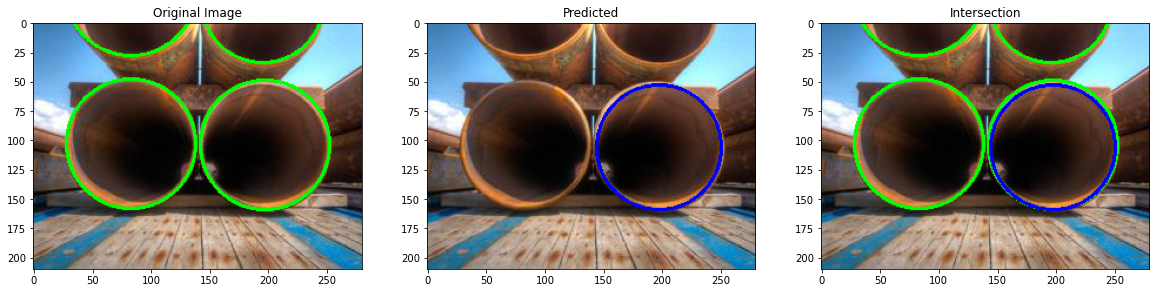

In [ ]:
file = "95"
example(file)

In the image below, the algorithm detects a circle in the noise cloud, due to the high noise (especially tree branches). 

Intersection over Union Score    75.48
Num of Circle in Original         4.00
Num of Circle in Predicted       21.00
Number of intersecting circle     2.00
Name: 44.txt, dtype: float64


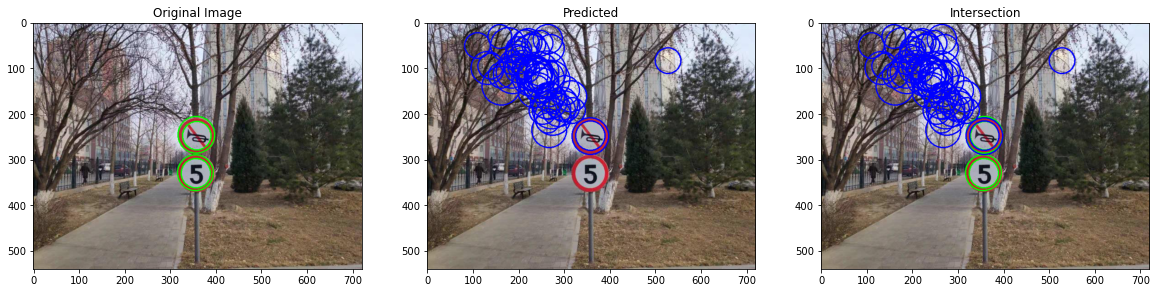

In [ ]:
file = "44"
example(file)
print(df_results.loc[file + ".txt"])

There are some important details in the image below. As seen in the image, the algorithm has difficulty recognizing some circles because they are not a regular circle shape. It is also observed that the detection of some colors in the image is better than other colors. **Finally, it is observed that there are circles that are not detected in the main data and are detected by the algorithm.** 

Intersection over Union Score    32.26
Num of Circle in Original        11.00
Num of Circle in Predicted       11.00
Number of intersecting circle     5.00
Name: 45.txt, dtype: float64


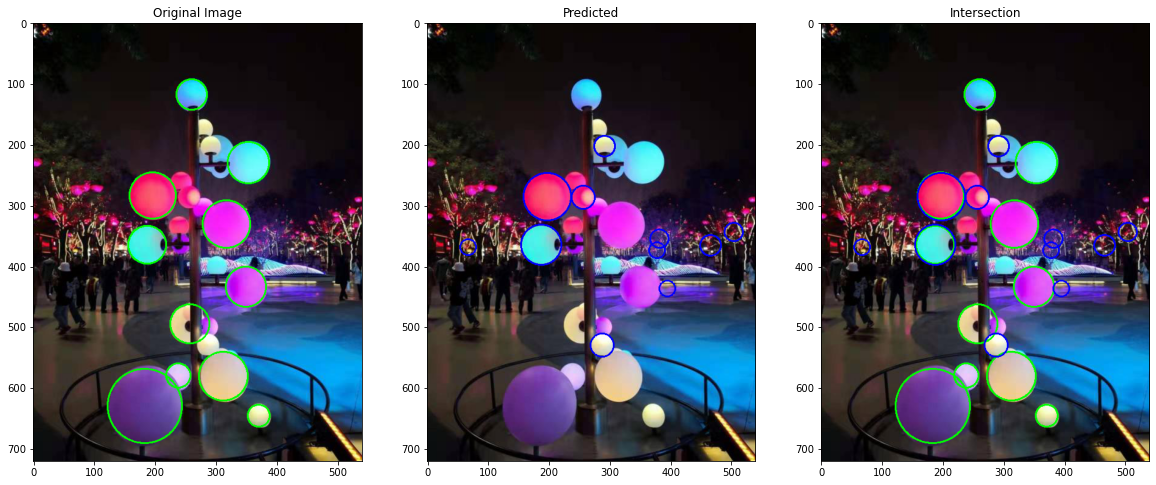

In [ ]:
file = "45"
example(file)
print(df_results.loc[file + ".txt"])

It is observed that the algorithm predicts the nested circles as a single circle in the image below. 

Intersection over Union Score    67.8
Num of Circle in Original         3.0
Num of Circle in Predicted        1.0
Number of intersecting circle     3.0
Name: 38.txt, dtype: float64


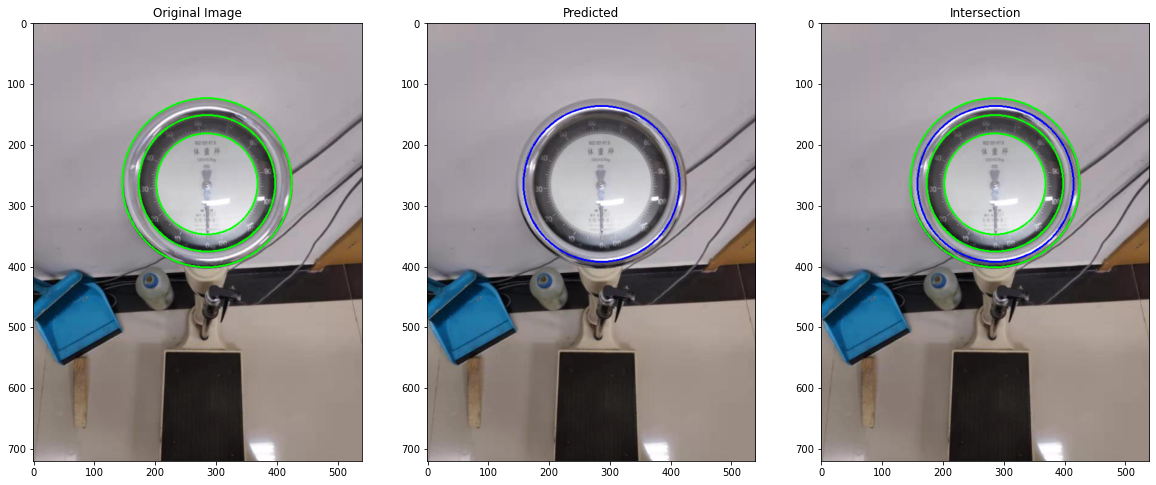

In [ ]:
file = "38"
example(file)
print(df_results.loc[file + ".txt"])

In the image below, which is thought to be easy to detect at first, things get difficult for the algorithm. The main reason for this is that when you pay attention to the plates, it has been observed that there are circular motifs in the plate and the algorithm cannot make a good decision at this point. 

Intersection over Union Score    48.14
Num of Circle in Original        12.00
Num of Circle in Predicted        1.00
Number of intersecting circle     4.00
Name: 8.txt, dtype: float64


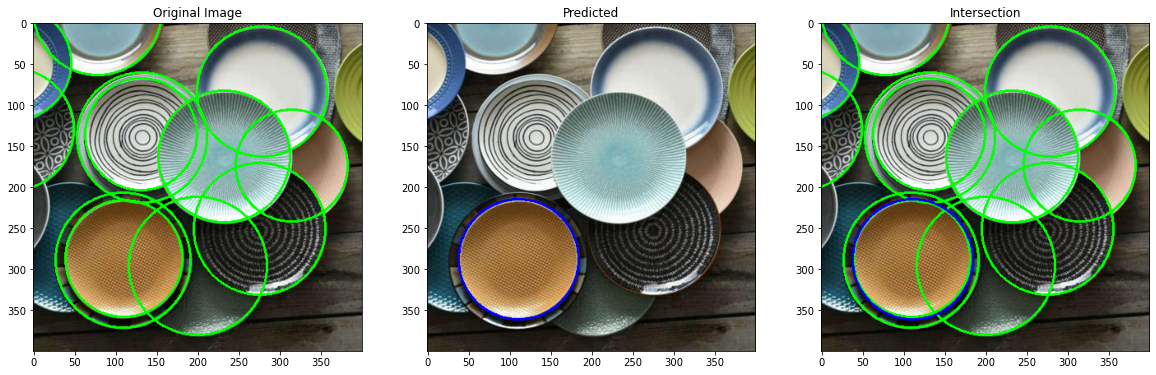

In [ ]:
file = "8"
example(file)
print(df_results.loc[file + ".txt"])

## 6. Conclusion <a name='6'></a>

In this assignment, Edge Detectors and Hough Transform are examined. Information on these subjects was given, and analyzes were made with their codes. In these analyzes, visual and numerical data are shared above.

When we look at the results, it is seen that a simple algorithm can recognize the circles on the image. It is observed that the higher the number of noise in the image, the more errors the algorithm gives. It has been observed that the algorithm has difficulty in finding semi-circles, and there are intersections in some circles that are irrelevant to the subject. However, in general, it can be said that the results can be interpreted positively. 

## 7. References <a name='7'></a>

[1] Haichun Yang and Ruining Deng and Yuzhe Lu and Zheyu Zhu and Ye Chen and Joseph T. Roland and Le Lu and Bennett A. Landman and Agnes B. Fogo and Yuankai Huo. CircleNet: Anchor-free Detection with Circle Representation., 2020.

[2] Assoc. Prof. Dr. Nazlı İkizler Cinbiş, BBM 418 - Computer Vision Laboratory Programming Assignment-1, 2022

[3] Qi Han and Kai Zhao and Jun Xu and Ming{-}Ming Cheng. Deep Hough Transform for Semantic Line Detection, 2020.